In [0]:
# Education - Udacity "Intro to TensorFlow for Deep Learning"
# Module: Forecasting with Convolutional Neural Network Recurrent Neural Network
# REF: https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb

In [2]:
# Import packages.
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt

# Using version 2.x of Tensorflow.
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Tensorflow.
import tensorflow as tf

# Print Tensorflow version.
print('TensorFlow Version:', tf.__version__)

TensorFlow 2.x selected.
TensorFlow Version: 2.1.0


In [0]:
# ====================
# Helper Function
# ====================
# Plot serie.
def plot_series(time, series, format="-", start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)


# Trend.
def trend(time, slope=0):
  return slope * time


# Seasonal pattern.
def seasonal_pattern(season_time):
  # Just an arbitrary pattern.
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))


# Seasonality.
def seasonality(time, period, amplitude=1, phase=0):
  # Repeats the same pattern at each period.
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


# White noise.
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


# Sequence to sequence dataset.
def seq2seq_window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)


# Predict function.
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

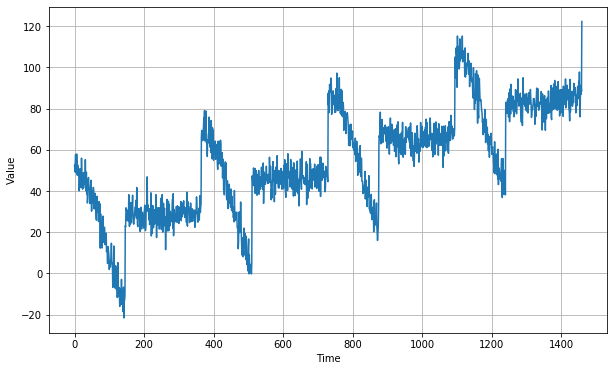

In [5]:
# Create dataset.
time      = np.arange(4 * 365 + 1)
slope     = 0.05
baseline  = 10
amplitude = 40
series    = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

noise_level = 5
noise       = white_noise(time, noise_level, seed = 42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
# Prepare for machine learning.
split_time    = 1000
time_train    = time[:split_time]
series_train  = series[:split_time]
time_valid    = time[split_time:]
series_valid  = series[split_time:]

In [10]:
# ==================
# 1D CNN RNN Forecasting
# ==================
# Clear session, just useful under development, as we usually
# run the session multiple time in the notebook.
SEED        = 42
WINDOW_SIZE = 30
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

dataset_train = seq2seq_window_dataset(series_train, WINDOW_SIZE, batch_size = 128)

# Build the model.
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1,
                         padding = "causal", activation = "relu",
                         input_shape = [None , 1]),
  tf.keras.layers.LSTM(100, return_sequences = True),
  tf.keras.layers.LSTM(100, return_sequences = True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)
model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9),
  metrics = ["mae"]
)
history = model.fit(dataset_train, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 9s 1s/step - loss: 51.9784 - mae: 52.7944
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 47.7474 - mae: 48.2956
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 35.6842 - mae: 36.4971
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 26.5602 - mae: 27.2039
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 23.3205 - mae: 23.8557
Epoch 6/100
8/8 [==============================] - 0s 27ms/step - loss: 22.3253 - mae: 22.8797
Epoch 7/100
8/8 [==============================] - 0s 25ms/step - loss: 21.9206 - mae: 22.4148
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 21.4396 - mae: 21.9760
Epoch 9/100
8/8 [==============================] - 0s 26ms/step - loss: 21.1313 - mae: 21.5520
Epoch 10/100
8/8 [==============================] - 0s 22ms/step - loss: 20.6408 - mae: 21.1713
Epoch 11/100
8/8 [==============================] -

[1e-08, 0.0001, 0, 30]

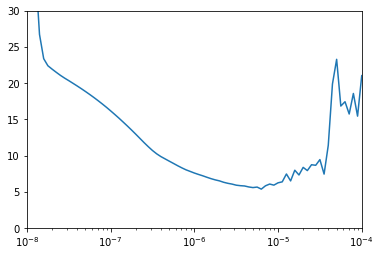

In [11]:
# Find the optimal learning rate.
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [0]:
# As we see that it would be safe to start with between 1e-6 and 1e-5.
# We will use 1e-5, even it would be risky.

In [14]:
# Update model with the learning rate.
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

checkpoint_name = "cnn_rnn_checkpoint.h5"
dataset_train   = seq2seq_window_dataset(series_train, WINDOW_SIZE, batch_size = 128)
dataset_valid   = seq2seq_window_dataset(series_valid, WINDOW_SIZE, batch_size = 128)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1,
                         padding = "causal", activation = "relu",
                         input_shape = [None , 1]),
  tf.keras.layers.LSTM(100, return_sequences = True),
  tf.keras.layers.LSTM(100, return_sequences = True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9),
  metrics = ["mae"]
)

early_stopping    = tf.keras.callbacks.EarlyStopping(patience = 50)
model_checkpoint  = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, save_best_only = True)
model.fit(
  dataset_train,
  epochs = 500,
  validation_data = dataset_valid,
  callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/500
8/8 [==============================] - 3s 330ms/step - loss: 16.3830 - mae: 17.1847 - val_loss: 21.2846 - val_mae: 21.7261
Epoch 2/500
8/8 [==============================] - 0s 32ms/step - loss: 12.4900 - mae: 12.9717 - val_loss: 10.0197 - val_mae: 10.5438
Epoch 3/500
8/8 [==============================] - 0s 37ms/step - loss: 9.4115 - mae: 10.0130 - val_loss: 11.2287 - val_mae: 11.6215
Epoch 4/500
8/8 [==============================] - 0s 40ms/step - loss: 7.3675 - mae: 7.9000 - val_loss: 9.6951 - val_mae: 10.2504
Epoch 5/500
8/8 [==============================] - 0s 34ms/step - loss: 6.4442 - mae: 6.9578 - val_loss: 9.0350 - val_mae: 9.5735
Epoch 6/500
8/8 [==============================] - 0s 38ms/step - loss: 5.9589 - mae: 6.4506 - val_loss: 8.2466 - val_mae: 8.7525
Epoch 7/500
8/8 [==============================] - 0s 37ms/step - loss: 5.7958 - mae: 6.2743 - val_loss: 7.4575 - val_mae: 7.9396
Epoch 8/500
8/8 [==============================] - 0s 36ms/step - loss: 5.754

In [0]:
# Load best model.
model = tf.keras.models.load_model(checkpoint_name)

In [16]:
# Forcast the model.
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]
rnn_forecast.shape

(461,)

MAE: 4.9135303


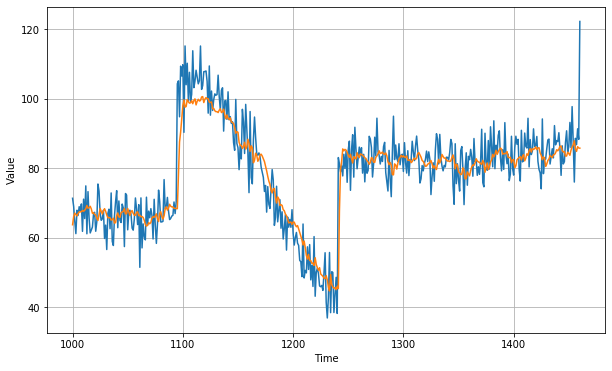

In [17]:
# Plot the forecast.
plt.figure(figsize = (10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

mae = tf.keras.metrics.mean_absolute_error(series_valid, rnn_forecast).numpy()
print("MAE:", mae)